## A very dirty but quick analysis of resting state networks on Gordon2014 atlas

In [2]:
from python.acnets.pipeline.parcellation import Parcellation
import pandas as pd
import numpy as np
import pygal as pg

In [159]:
p = Parcellation('gordon2014_2mm').fit()

ts_pool = []

for ts in p.dataset_['timeseries']:
  subj_ts = {
    'timeseries': [t for t in ts.values.T],
    'network': p.dataset_['network'].to_series()
  }
  subj_ts = pd.DataFrame(subj_ts)
  subj_ts['subject'] = ts['subject'].values
  
  ts_pool.append(subj_ts)

net_ts = pd.concat(ts_pool).reset_index()
mean_net_ts = net_ts.groupby(['network','subject'])['timeseries'].apply(lambda ts: np.mean(ts))


In [180]:

def get_net_ts(all_net_ts):
  # mean_net_ts = mean_net_ts.to_frame().query('index.get_level_values(1) == "AVGP03"')
  subjs_nets = all_net_ts.groupby('subject').apply(list)
  ts = [np.array(s).T for s in subjs_nets]
  lbl = all_net_ts.index.get_level_values(0).unique()
  return ts, lbl

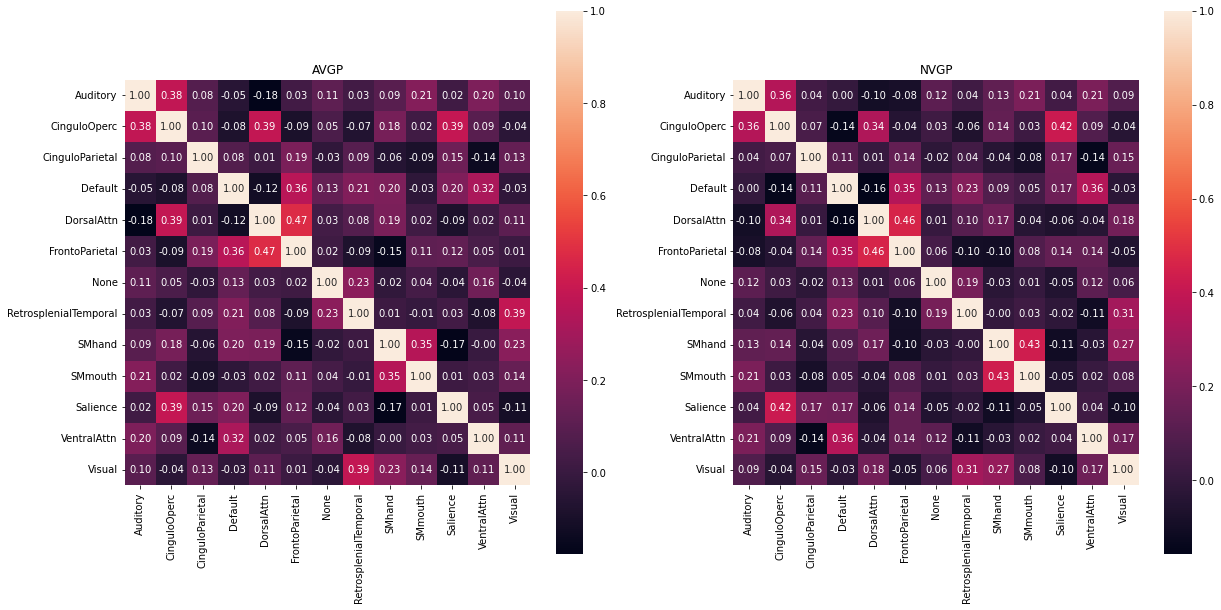

In [222]:
from python.acnets.connectome import ExtraConnectivityMeasure
conn = ExtraConnectivityMeasure(kind='partial correlation', vectorize=False)
import seaborn as sns

_, axes = plt.subplots(1, 2, figsize=(20,10))

# AVGP
avgp = mean_net_ts.to_frame().query('index.get_level_values(1).str.startswith("A")')['timeseries']
ts, lbl = get_net_ts(avgp)

avgp_conn_mean = conn.fit_transform(ts).mean(axis=0)

sns.heatmap(avgp_conn_mean,
            ax=axes[0],
            square=True, annot=True, fmt='.2f', xticklabels=lbl, yticklabels=lbl)
axes[0].set_title('AVGP')

# NVGP
nvgp = mean_net_ts.to_frame().query('index.get_level_values(1).str.startswith("N")')['timeseries']
ts, lbl = get_net_ts(nvgp)
nvgp_conn_mean = conn.fit_transform(ts).mean(axis=0)

sns.heatmap(nvgp_conn_mean,
            ax=axes[1],
            square=True, annot=True, fmt='.2f', xticklabels=lbl, yticklabels=lbl)
axes[1].set_title('NVGP')
plt.show()

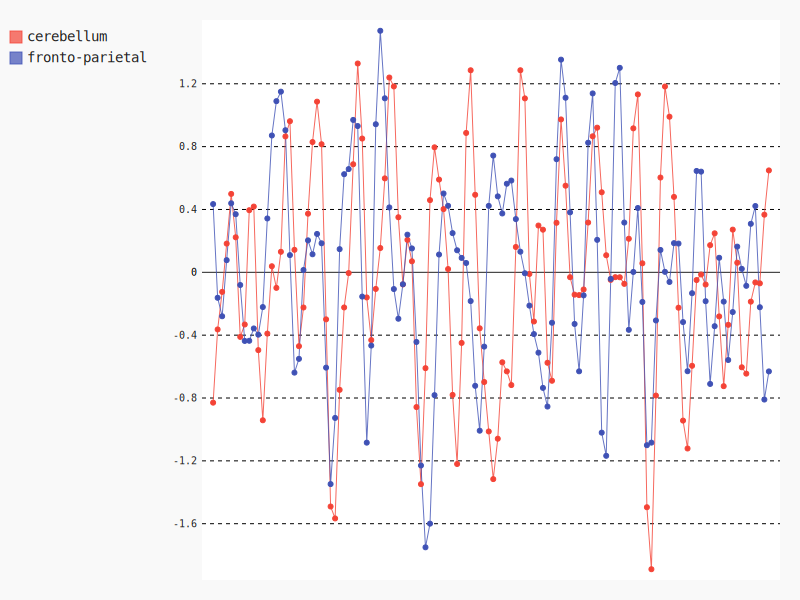

In [81]:
chart = pg.Line(_self_close=False, _max=10)

for (network,subject),data  in mean_net_ts['timeseries'].iteritems():
  if network in ['cerebellum','fronto-parietal']:
    chart.add(network, data)

from IPython.display import SVG
SVG(chart.render())

# Again, a very dirty but quick EPI signal level in Cerebellum

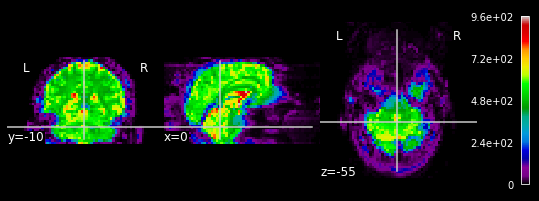

In [240]:
from nilearn import image, plotting
import nibabel as nib 

rs_images = nib.load(
  '/Users/morteza/workspace/acnets/data/julia2018/sub-AVGP01/ses-rest/func/'
  'sub-AVGP01_ses-rest_task-rest_bold.nii.gz')

# TODO apply simple preprocessing strategy before plotting

# plot mean image
mean_image = image.mean_img(rs_images)
plotting.plot_epi(mean_image,cut_coords=(0,-10,-55), colorbar=True)

## Dirty Network masker

In [131]:
from nilearn import maskers, datasets, plotting, image, surface
import numpy as np
from python.acnets.parcellations import gordon

atlas = gordon.fetch_atlas()

maps_data = image.get_data(atlas['maps'])
atlas.labels['network'] = atlas.labels['network'].astype('category')
region2network_mapping = atlas.labels['network'].cat.codes + 1
region2network_mapping = region2network_mapping.to_dict()
# atlas.labels['network'].cat.categories
none_regions = atlas.labels.query('network == "None"').index
none_idx = atlas.labels['network'].cat.categories.to_list().index('None') + 1
map_r2n = lambda x: region2network_mapping[int(x)] if x not in [0,none_idx] else 0
maps_data = np.vectorize(map_r2n)(maps_data)

new_maps = image.new_img_like(atlas['maps'], maps_data)
new_maps.to_filename('a.nii.gz')

fsaverage = datasets.fetch_surf_fsaverage()

# plotting.plot_epi(new_maps, colorbar=True)
# plotting.plot_img(new_maps, colorbar=True)
# plotting.plot_roi(new_maps, title='Gordon Atlas', colorbar=True)

# aa = surface.vol_to_surf(new_maps, fsaverage.pial_left)

# plotting.view(fsaverage['pial_left'], roi_map=aa,
#                        hemi='left', view='lateral',
#                        bg_map=fsaverage['sulc_left'], bg_on_data=True,
#                        darkness=.5)

plotting.view_img(new_maps, symmetric_cmap=False).open_in_browser()

# plotting.view_surf(fsaverage.white_right, aa).open_in_browser()
# plotting.plot_glass_brain(new_maps, colorbar=True, annotate=True)
# plotting.plot_epi(net_maps,cut_coords=(0,-10,-55), colorbar=True)

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [105]:
atlas.labels['network'].cat.categories

Index(['Auditory', 'CinguloOperc', 'CinguloParietal', 'Default', 'DorsalAttn',
       'FrontoParietal', 'None', 'RetrosplenialTemporal', 'SMhand', 'SMmouth',
       'Salience', 'VentralAttn', 'Visual'],
      dtype='object')